In [1]:
from sklearn.decomposition import PCA
from load_cifar10 import load_cifar10
from shental_gmm import GMM
from utils import scatter_points
import numpy as np
import mnist
from matplotlib import pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.metrics import homogeneity_score
from sklearn.metrics import adjusted_rand_score as ars

In [2]:
plt.rcParams["figure.figsize"] = (7,6)

<h3>Load Data</h3>

In [3]:
def load_data(dataset, pca_components=None, points=2000):
    if dataset == "cifar10":
        X, y = load_cifar10()
        X = X[:points]
        X = X.reshape(X.shape[0], -1) / 255
        if pca_components is not None:
            pca = PCA(n_components=pca_components)
            X = pca.fit_transform(X)
        return X, np.squeeze(y[:points])
    
    elif dataset == "mnist":
        X = mnist.train_images()[:points]
        y = mnist.train_labels()[:points]
        X = X.reshape(X.shape[0], -1) / 255
        if pca_components is not None:
            pca = PCA(n_components=pca_components)
            X = pca.fit_transform(X)
        return X, y
    
    elif dataset == "brain":
        import pandas as  pd
        rnaseqtpm = pd.read_csv(
            '~/CMU/cellar/datasets/brain/RNAseqTPM.csv', index_col=0, header=None).T
        X = rnaseqtpm.to_numpy()
        if pca_components is not None:
            pca = PCA(n_components=pca_components)
            X = pca.fit_transform(X)
        return X, []
    
    elif dataset == "spleen":
        import anndata, pickle
        X = anndata.read_h5ad('/home/zekrom/CMU/cellar/datasets/spleen/dim_reduced_clustered.h5ad').X
        X = X[:points]
        with open("dumps/labels_spleen.pkl", "rb") as f:
            y = pickle.load(f)
        if pca_components is not None:
            pca = PCA(n_components=pca_components)
            X = pca.fit_transform(X)
        return X, y[:points]

In [4]:
dataset = "spleen"

In [5]:
X, y = load_data(dataset, pca_components=15, points=2000)

In [6]:
np.unique(y, return_counts=True)

(array([0, 1, 2, 3], dtype=int32), array([1299,  552,   47,  102]))

In [7]:
print('sscore', silhouette_score(X, y))
print(X.shape)

sscore 0.32143736
(2000, 15)


<h3>Train</h3>

In [87]:
def get_random_ml(y, ml_n=50):
    indices = {i:[] for i in np.unique(y)}
    
    lbs = np.arange(y.shape[0])
    np.random.shuffle(lbs)
    for i in lbs:
        indices[y[i]].append(i)
        total = 0
        for j in indices:
            if len(indices[j]) > 0:
                total += len(indices[j]) - 1
        if total >= ml_n:
            break
    
    ml = []
    for i in indices:
        for j in indices[i][1:]:
            ml.append((indices[i][0], j))
    return ml

In [88]:
def train(X, y, ml_n=50, n_clusters=10, n_steps=20):
    gmm = GMM(n_clusters=n_clusters, n_steps=n_steps)
    ml = get_random_ml(y, ml_n=ml_n)
    print(f'Adding {len(ml)} constraints.')
    gmm.fit(X, ml)
    return gmm

In [ ]:
gmms = []

In [ ]:
for i in range(0, 501, 50):
    gmm = train(X, y, ml_n=i, n_clusters=4)
    gmms.append(gmm)

In [ ]:
import pickle
with open(f"dumps/gmm_{dataset}_0to25.pkl", "wb") as f:
    pickle.dump(gmms, f)

In [8]:
import pickle
with open(f"dumps/gmm_{dataset}_0to25.pkl", "rb") as f:
    gmms = pickle.load(f)

<h3>Plotting</h3>

In [9]:
def plot_ll(lls, labels, title=None, ylabel="loglikelihood", path=None):
    for ll, lbl in zip(lls, labels):
        plt.plot(ll[1:], label=lbl)
        plt.legend(loc=3)
        plt.xlabel("iterations", fontsize=18)
        plt.ylabel(ylabel, fontsize=18)
        if title is not None:
            plt.title(title)
        plt.xticks(np.arange(len(lls[0])))
    if path is not None:
        plt.savefig(path)
    plt.show()

In [10]:
lls = [i.lls for i in gmms]
scores = [i.scores for i in gmms]
homos = [homogeneity_score(i.get_labels(), y) for i in gmms]
arscores = [ars(i.get_labels(), y) for i in gmms]

names = np.arange(0, 501, 50) / 20
names = [str(i) + "%" for i in names]

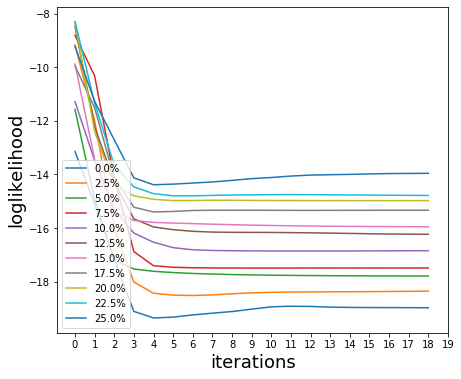

In [11]:
plot_ll(lls, names, ylabel="loglikelihood", path=f"images/{dataset}_lls.png")

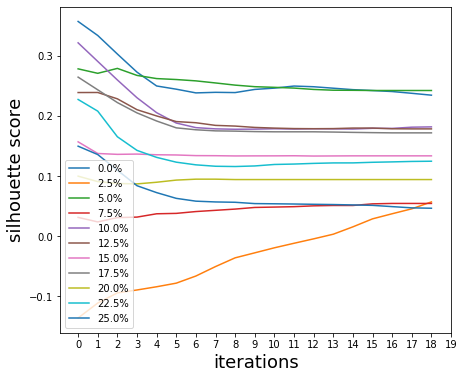

In [12]:
plot_ll(scores, names, ylabel="silhouette score", path=f"images/{dataset}_scores.png")

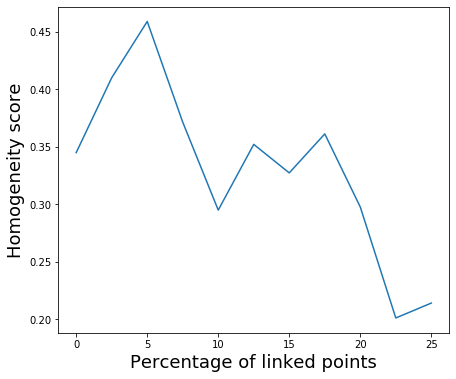

In [14]:
from matplotlib.ticker import FormatStrFormatter
fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.plot(np.arange(0, 501, 50) / 20, homos)
ax.set_xlabel("Percentage of linked points", fontsize=18)
ax.set_ylabel("Homogeneity score", fontsize=18)
plt.savefig(f"images/{dataset}_homog.png")
plt.show()

In [ ]:
plt.plot(np.arange(0, 501, 50) / 20, arscores)
plt.xlabel("Percentage of linked points")
plt.ylabel("Adjusted rand score")
plt.title(dataset)
plt.savefig(f"images/{dataset}_ars.png")
plt.show()

<h3>Visualize</h3>

In [103]:
import umap
X_emb = umap.UMAP(n_components=2).fit_transform(X)

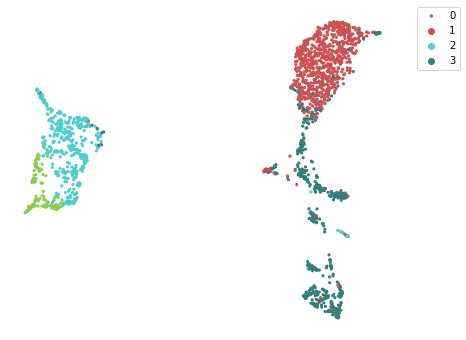

In [104]:
labels = gmms[2].get_labels()
scatter_points(X_emb[:, 0], X_emb[:, 1], labels=labels)